In [102]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = "/usr/bin/Rscript"
from cdt.independence import graph
from pathlib import Path
from cdt.causality.graph import PC
import matplotlib.pyplot as plt
import networkx as nx

In [103]:
data_path = Path('/home/ralmasri/projects/Thesis/Domain-Guided-Monitoring/data/')
csv_path = data_path / "logs_aggregated_concurrent.csv"
size = 50
subset_path = data_path / f"{size}_logs_aggregated_concurrent.csv" if size > 0 else csv_path
data_df = pd.read_csv(data_path / "50_huawei_df.csv").fillna("")
data_df = data_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
data_df.head()

,log_level,coarse_log_cluster_template,http_method,http_status,url_cluster_template,programname,Hostname,fine_log_cluster_template,python_module
0,info,get v20 networks shared true http 11 status 20...,,,,neutron-server,wally113,get v20 networks shared true http 11 status 20...,neutron.wsgi
1,info,get v20 ports fields binding 3ahost id fields ...,,,,neutron-server,wally113,get v20 ports fields binding 3ahost id fields ...,neutron.wsgi
2,info,get v20 ports tenant id 99c2677b197747c9bd8bc0...,,,,neutron-server,wally113,get v20 ports tenant id 99c2677b197747c9bd8bc0...,neutron.wsgi
3,info,get v20 networks shared true http 11 status 20...,,,,neutron-server,wally113,get v20 networks shared true http 11 status 20...,neutron.wsgi
4,info,get v20 networks tenant id 99c2677b197747c9bd8...,,,,neutron-server,wally113,get v20 networks tenant id 99c2677b197747c9bd8...,neutron.wsgi


In [104]:
# vocab
vocab = {}
i = 0
for _, row in data_df.iterrows():
    for column in data_df.columns:
        name = column + "#" + str(row[column]).lower()
        if name not in vocab and row[column] != "":
            vocab[name] = i
            i += 1
[list(vocab.items())[x] for x in range(10)]

[('log_level#info', 0),
 ('coarse_log_cluster_template#get v20 networks shared true http 11 status 200 len 213 time *',
  1),
 ('programname#neutron-server', 2),
 ('Hostname#wally113', 3),
 ('fine_log_cluster_template#get v20 networks shared true http 11 status 200 len 213 time *',
  4),
 ('python_module#neutron.wsgi', 5),
 ('coarse_log_cluster_template#get v20 ports fields binding 3ahost id fields binding 3avif type device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00377178',
  6),
 ('fine_log_cluster_template#get v20 ports fields binding 3ahost id fields binding 3avif type device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00377178',
  7),
 ('coarse_log_cluster_template#get v20 ports tenant id 99c2677b197747c9bd8bc0d8a44a0fb6 device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00277810',
  8),
 ('fine_log_cluster_template#get v20 ports tenant id 99c2677b197747c9bd8bc0d8a44a0fb6 device id 7c9e94497d8140d082dbe3e05

In [105]:
alg_df = pd.DataFrame()
for column in list(vocab.keys()):
    attribute, value = tuple(column.split('#'))
    if column not in alg_df.columns:
        alg_df[column] = data_df[attribute].apply(lambda x: 1 if x == value else 0)
    else:
        alg_df[column] |= data_df[attribute].apply(lambda x: 1 if x == value else 0)
alg_df.head()

,log_level#info,coarse_log_cluster_template#get v20 networks shared true http 11 status 200 len 213 time *,programname#neutron-server,Hostname#wally113,fine_log_cluster_template#get v20 networks shared true http 11 status 200 len 213 time *,python_module#neutron.wsgi,coarse_log_cluster_template#get v20 ports fields binding 3ahost id fields binding 3avif type device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00377178,fine_log_cluster_template#get v20 ports fields binding 3ahost id fields binding 3avif type device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00377178,coarse_log_cluster_template#get v20 ports tenant id 99c2677b197747c9bd8bc0d8a44a0fb6 device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00277810,fine_log_cluster_template#get v20 ports tenant id 99c2677b197747c9bd8bc0d8a44a0fb6 device id 7c9e94497d8140d082dbe3e0536f5afd http 11 status 200 len 210 time 00277810,...,fine_log_cluster_template#19 nov 2019 17 03 34 get v2 images 7d4ee607be1441d2835068c9e7650545 http 11 200 1133 0018593,fine_log_cluster_template#19 nov 2019 17 03 36 get v2 images 8fe28b4c65654ea9b4c326e71ea91e34 http 11 200 851 0021504,fine_log_cluster_template#19 nov 2019 17 03 * delete v2 images * http 11 204 213 *,coarse_log_cluster_template#19 nov 2019 17 03 37 post v2 images http 11 201 1002 0127570,fine_log_cluster_template#19 nov 2019 17 03 37 post v2 images http 11 201 1002 0127570,fine_log_cluster_template#19 nov 2019 17 03 39 get v2 schemas image http 11 200 5562 *,log_level#warning,coarse_log_cluster_template#since image size is zero we will be doing resizebeforewrite for each chunk which will be considerably slower than normal,fine_log_cluster_template#since image size is zero we will be doing resizebeforewrite for each chunk which will be considerably slower than normal,python_module#glance_store._drivers.rbd
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
obj = PC()
output : nx.DiGraph = obj.predict(alg_df)
print(f"Number of nodes: {output.number_of_nodes()}")
print(f"Number of edges: {output.number_of_edges()}")

Number of nodes: 66
Number of edges: 80


In [107]:
causality_records = []
for edge in list(output.edges()):
    from_value, to_value = edge
    causality_records.append(
        {
            "parent_id": from_value,
            "parent_name": from_value.split("#")[1],
            "child_id": to_value,
            "child_name": to_value.split("#")[1],
        },
    )
causality_df = pd.DataFrame.from_records(causality_records).drop_duplicates().reset_index(drop=True)
causality_df

,parent_id,parent_name,child_id,child_name
0,log_level#info,info,http_method#get,get
1,log_level#info,info,programname#keystone-apache-public-access,keystone-apache-public-access
2,coarse_log_cluster_template#get v20 networks s...,get v20 networks shared true http 11 status 20...,fine_log_cluster_template#get v20 networks sha...,get v20 networks shared true http 11 status 20...
3,programname#neutron-server,neutron-server,python_module#neutron.wsgi,neutron.wsgi
4,fine_log_cluster_template#get v20 networks sha...,get v20 networks shared true http 11 status 20...,coarse_log_cluster_template#get v20 networks s...,get v20 networks shared true http 11 status 20...
...,...,...,...,...
75,fine_log_cluster_template#since image size is ...,since image size is zero we will be doing resi...,coarse_log_cluster_template#since image size i...,since image size is zero we will be doing resi...
76,fine_log_cluster_template#since image size is ...,since image size is zero we will be doing resi...,python_module#glance_store._drivers.rbd,glance_store._drivers.rbd
77,python_module#glance_store._drivers.rbd,glance_store._drivers.rbd,log_level#warning,warning
78,python_module#glance_store._drivers.rbd,glance_store._drivers.rbd,coarse_log_cluster_template#since image size i...,since image size is zero we will be doing resi...


In [108]:
import pickle
df = pickle.load( open( "/home/ralmasri/Downloads/df_causal_discovery.p", "rb") )
print(df.shape)
df

(29170, 7)


,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0
...,...,...,...,...,...,...,...
32556,27,38,0,0,1,1,0
32557,40,40,0,1,1,0,1
32558,58,40,0,0,1,1,0
32559,22,20,0,0,1,0,0


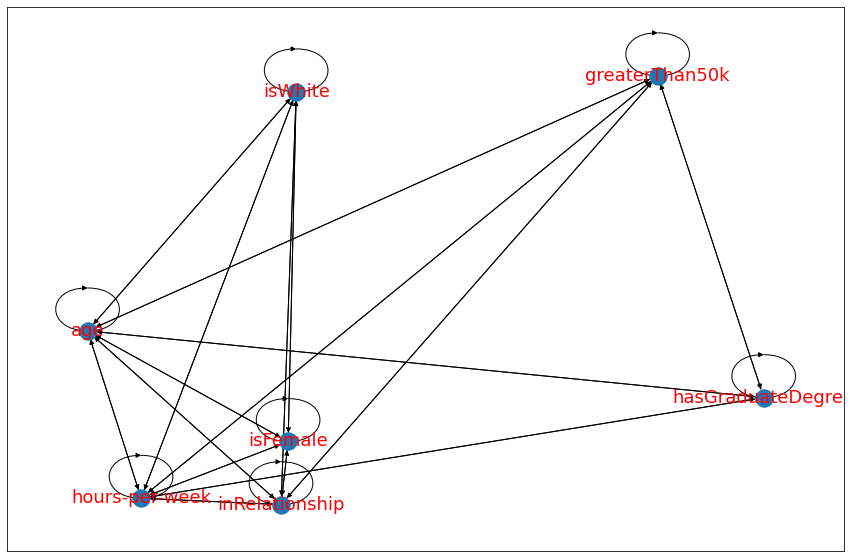

In [109]:
glasso = graph.Glasso()
skeleton = glasso.predict(df)
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')